<a href="https://colab.research.google.com/github/kabhishek20/Chat_Analysis/blob/main/Data_Shortage_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_text
!pip install datefinder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 87.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### **Importing Required Libraries**

In [ ]:
import pickle
from datetime import datetime
import requests
import warnings
import datefinder
import pandas as pd
import numpy as np
import tensorflow_text as text
import tensorflow as tf
import tensorflow_hub as hub

### **Pre-Processing Data**

In [ ]:
def data_preprocess(df):
    df["Status"] = df["Status"].str.lower()
    df.loc[df["Status"] == "resolved", "Information_Available"] = "available"
    df.loc[df["Status"] == "to be discontinued", "Information_Available"] = "not available"
    df.loc[df["Status"] == "current", "Status"] = " "
    return (df)

###**Data Cleaning**

In [ ]:
def data_clean(df):
    df.drop([" Type of Update", " Resolved Note", " Change Date", " Date Discontinued", " Generic Name Note",
             " Generic Name Link ", " Company Info Link", " Availability Link", " Related Info Link",
             "   Resolved Note Link", " Discontinued Note Link"], axis=1, inplace=True)
    df.columns = ['Generic_Drug_Name', 'Company_Name', 'Contact_Information', 'Product_details', 'Last_FDA_Update',
                  'Available_Information', 'Related_Information', 'Reason_for_shortage', 'Therapeutic_Category',
                  'Status', 'Initial_FDA_Update']
    df["Last_FDA_Update"].fillna(df["Initial_FDA_Update"], inplace=True)
    df["Initial_FDA_Update"].fillna(df["Last_FDA_Update"], inplace=True)
    df["Contact_Information"].fillna("No Contact Information present", inplace=True)
    df["Therapeutic_Category"].fillna("No Category described", inplace=True)
    df["Reason_for_shortage"].fillna("Reason not known", inplace=True)
    df["Available_Information"].fillna(" ", inplace=True)
    df["Related_Information"].fillna(" ", inplace=True)
    df['Information_Available'] = df['Available_Information'] + ' ' + df['Related_Information']
    df.drop(['Available_Information', 'Related_Information'], axis=1, inplace=True)
    return (df)

###**Model Classification**

In [ ]:
def current_shortage():
    url = "https://www.accessdata.fda.gov/scripts/drugshortages/Drugshortages.cfm"
    response = requests.get(url)
    if response.status_code == 200:
        df = pd.read_csv(url)
        # df=pd.read_csv("/content/Drugshortages_for_testing.csv")
        df = data_clean(df)
        df = data_preprocess(df)
        model = tf.keras.models.load_model('/content/drive/MyDrive/272 PROJECT/BERT_fine_tuned_model.h5',custom_objects={'KerasLayer': hub.KerasLayer})
        result = model.predict(df["Information_Available"])
        result = result.flatten()
        result= np.where(result > 0.5, 1, 0)
        # df["model_prediction"]=result
        df['model_prediction'] = np.where(df['model_prediction'] == 1, 'Shortage', 'No Shortage')
        return(df)
    else:
        print("Failed to update.")

###**Returning Output**

In [ ]:
def extract_dates_from_sentence(sentence):
    sentence = sentence.replace("Q1","January").replace("Q2","April").replace("Q3","July").replace("Q4","October")
    dates = []
    matches = datefinder.find_dates(sentence)
    for match in matches:
        dates.append(match)
    if len(dates)>0:
      return dates[0].date()
    else:
      return None

In [ ]:
def filter(df):
  for i in range(0,df.shape[0]):
    if "on allocation" in df["Information_Available"][i].lower():
      df["model_prediction"][i]=1
    if "contracted customers" in df["Information_Available"][i].lower():
      df["model_prediction"][i]=1
    date=extract_dates_from_sentence(df["Information_Available"][i])
    # print(date)
    if date is not None:
      if date>datetime.now().date():
        df["model_prediction"][i]=1
        # print("Hi")
      else:
        df["model_prediction"][i]=0
  return(df)


In [ ]:
if __name__ == "__main__":
    df = current_shortage()
    df = filter(df)
    df.to_csv("BERT_output.csv", index=False)

94/94 [==============================] - 31s 326ms/step


<ipython-input-34-39e5a7ffc225>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["model_prediction"][i]=1
<ipython-input-34-39e5a7ffc225>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["model_prediction"][i]=1
<ipython-input-34-39e5a7ffc225>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["model_prediction"][i]=1
<ipython-input-34-39e5a7ffc225>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [ ]:
# from sklearn.metrics import classification_report

In [ ]:
# print(classification_report(df["label"], df["model_prediction"]))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1596
           1       0.96      0.98      0.97      1412

    accuracy                           0.97      3008
   macro avg       0.97      0.97      0.97      3008
weighted avg       0.97      0.97      0.97      3008



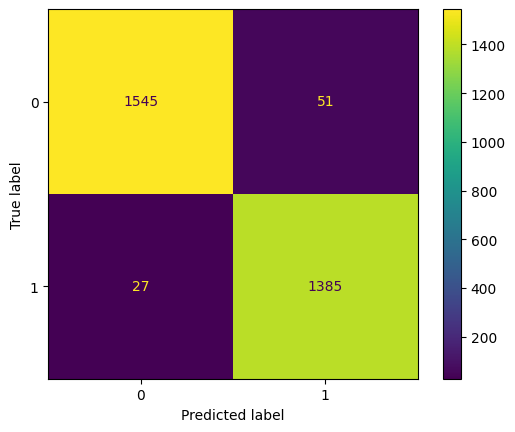

In [ ]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt
# %matplotlib inline

# ConfusionMatrixDisplay.from_predictions(df["label"], df["model_prediction"])
# # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
# # disp.plot()
# plt.show()